In [255]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime as dt

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
PATH_TO_DATA = '/home/marius/Jülich/COSY Beamtime spring 2018/'

In [221]:
# systematic measurements
RUNS = range(32,104)
PARTICLES = ['Proton', 'Deuteron']
ENERGIES = [10,20,30,40]

In [222]:
# current sensitivity Be (full scale in nA)
sense = {34:10,
         35:10,
         36:10,
         37:10,
         38:10,
         39:10,
         40:10,
         41:10,
         42:10,
         43:10,
         44:10,
         45:10,
         46:10,
         47:10,
         48:10,
         49:10,
         50:10,
         51:10,
         52:10,
         53:10,
         54:0.1,
         55:0.1,
         56:0.1,
         57:0.1,
         58:0.1,
         59:0.1,
         60:0.1,
         61:0.1,
         62:0.1,
         63:0.1,
         64:0.1,
         65:1,
         66:1,
         67:1,
         68:1,
         69:1,
         70:1,
         71:1,
         72:1,
         73:1,
         74:1,
         75:1,
         76:1,
         77:1,
         78:1,
         79:1,
         80:1,
         81:1,
         82:1,
         83:0.1,
         84:0.1,
         85:0.1,
         86:0.1,
         87:0.1,
         88:0.1,
         89:0.1,
         90:0.1,
         91:0.1,
         92:0.1,
         93:0.1,
         94:0.1,
         95:0.1,
         96:0.1,
         97:0.1,
         98:0.1,
         99:0.1,
         100:0.1,
         101:0.1,
         102:0.1,
         103:0.1}
df_sense = pd.DataFrame(list(sense.items()), columns = ['run_number', 'curr_sense'])

### helper

In [223]:
def read_syst_data(run_number, particle, energy):
    df = pd.read_table(
        PATH_TO_DATA + 'RawData/Current/#{}_H3_Current_{}MeV_{}.dat'.format(run_number, energy, particle), 
        header = None, 
        delim_whitespace=True,
        names = ['timestamp',
                 '3-He_1',
                 '3-He_2',
                 '3-He_3',
                 '3-He_4',
                 '3-He_5',
                 '3-He_6',
                 '3-He_7',
                 'meas.',
                 'I_Be',
                 'I_J',
                 'I_FCT',
                 'I_BPML',
                 'I_BPMR',
                 'I_ICT'
                ]
    )
    return df

### data preparation

In [224]:
# put all systematic measurements in one dataframe

df = pd.DataFrame()

for run_number in RUNS:
    for particle in PARTICLES:
        for energy in ENERGIES:
            
            try:
                df_temp = read_syst_data(run_number, particle, energy)
                
                df_temp['run_number'] = run_number
                df_temp['particle'] = particle
                df_temp['energy [MeV]'] = energy
            except:
                pass
            
    df = df.append(df_temp)

In [331]:
# read gnumeric data and merge target information (+ additional)

summary = pd.read_table(PATH_TO_DATA + 'Summary.csv', sep = ',')
# get rid of empty lines and mixed runs
summary.dropna(subset = ['Run'], inplace = True)
summary = summary[(summary['Run'] != '#105/106') & (summary['Run'] != '#107/108')]
# prepare for merging
summary['run_number'] = summary['Run'].apply(str).apply(lambda row: row.strip('#')).apply(int)
summary.rename(
    columns = {'Unnamed: 10':'scale',
               'I Be':'I_Be mean',
               'Unnamed: 12':'I_Be std',
               'I J':'I_J mean',
               'Unnamed: 16':'I_J std',
               'I FCT':'I_FCT mean',
               'Unnamed: 18':'I_FCT std',
               'I ICT':'I_ICT mean',
               'Unnamed: 20':'I_ICT std',
              },
    inplace = True
)

In [226]:
# build aggregation dictionary
currents = [s for s in df.columns if 'I_' in s]

d = {}
for current in currents:
    d[current] = ['mean','std']
curr_dict = d

In [227]:
# calc. mean and std of currents for each run
df_currents = df.groupby(
    ['run_number',
     'particle',
     'energy [MeV]']
).agg(
    curr_dict
).reset_index()

# make multiindex to single level index for merging
df_currents.columns = [' '.join(col).strip() for col in df_currents.columns.values]

# calc. sum signal of BPML and BPMR
df_currents['I_BPMS mean'] = df_currents['I_BPML mean'] + df_currents['I_BPMR mean']
df_currents['I_BPMS std'] = np.sqrt(df_currents['I_BPML std']**2 + df_currents['I_BPMR std']**2)

In [228]:
df_currents.head()

,run_number,particle,energy [MeV],I_Be mean,I_Be std,I_J mean,I_J std,I_FCT mean,I_FCT std,I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean,I_ICT std,I_BPMS mean,I_BPMS std
0,32,Proton,40,-0.020442,0.031077,1.982148,0.447241,10.976903,0.064232,6.482896,0.085111,5.133938,0.087143,0.000252,0.027752,11.616834,0.121810
1,33,Proton,40,-0.020578,0.030934,3.429942,0.376962,10.304617,0.262332,6.465313,0.145798,5.190716,0.149527,0.000262,0.028330,11.656028,0.208843
2,34,Proton,40,0.083109,0.269519,0.915094,0.895642,4.327421,2.513941,1.752275,1.876376,1.018408,1.680033,0.000140,0.028256,2.770683,2.518591
3,35,Proton,40,0.039985,0.062917,3.025304,0.313791,9.204697,1.017498,5.396881,0.613262,4.188999,0.619018,0.000265,0.028223,9.585880,0.871363
4,36,Proton,40,0.024764,0.062015,2.243727,0.131426,6.883327,0.290023,3.892275,0.076886,2.702237,0.075832,0.000323,0.028256,6.594513,0.107990


In [245]:
# merge calc. currents with PZ currents & Target information
df_total = df_currents.merge(
    summary[
    ['Run',
     'Target',
     'scale',
     'Start',
     'End',
     'I_Be mean',
     'I_Be std',
     'I_J mean',
     'I_J std',
     'I_FCT mean',
     'I_FCT std',
     'I_ICT mean',
     'I_ICT std']
    ], 
    on = 'run_number',
    how = 'left',
    suffixes = ('_MR','_PZ')

In [246]:
df_total.head()

,run_number,particle,energy [MeV],I_Be mean_MR,I_Be std_MR,I_J mean_MR,I_J std_MR,I_FCT mean_MR,I_FCT std_MR,I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean_MR,I_ICT std_MR,I_BPMS mean,I_BPMS std,Target,scale,Start,End,I_Be mean_PZ,I_Be std_PZ,I_J mean_PZ,I_J std_PZ,I_FCT mean_PZ,I_FCT std_PZ,I_ICT mean_PZ,I_ICT std_PZ
0,32,Proton,40,-0.020442,0.031077,1.982148,0.447241,10.976903,0.064232,6.482896,0.085111,5.133938,0.087143,0.000252,0.027752,11.616834,0.121810,X,NaN,19:22:00,19:32:00,NaN,NaN,"1,98","0,44","10,9769","0,0642",NaN,NaN
1,33,Proton,40,-0.020578,0.030934,3.429942,0.376962,10.304617,0.262332,6.465313,0.145798,5.190716,0.149527,0.000262,0.028330,11.656028,0.208843,Be,NaN,20:05:00,20:15:00,NaN,NaN,"3,4299","0,377","10,3046","0,2623",NaN,NaN
2,34,Proton,40,0.083109,0.269519,0.915094,0.895642,4.327421,2.513941,1.752275,1.876376,1.018408,1.680033,0.000140,0.028256,2.770683,2.518591,Be,1,20:26:00,20:56:00,Error,NaN,"3,3912","0,4427","11,001","0,0004",NaN,NaN
3,35,Proton,40,0.039985,0.062917,3.025304,0.313791,9.204697,1.017498,5.396881,0.613262,4.188999,0.619018,0.000265,0.028223,9.585880,0.871363,X,1,21:32:00,22:02:00,"0,04","0,063","3,02","0,312","9,2047","1,017",NaN,NaN
4,36,Proton,40,0.024764,0.062015,2.243727,0.131426,6.883327,0.290023,3.892275,0.076886,2.702237,0.075832,0.000323,0.028256,6.594513,0.107990,X,1,22:11:00,22:41:00,"0,0248","0,062","2,2437","0,1314","6,8833","0,29",NaN,NaN


In [231]:
# compare MR and PZ calc. currents
df_total[
    [
        'run_number',
        'I_Be mean_MR',
        'I_Be mean_PZ'
    ]
].head(10)

,run_number,I_Be mean_MR,I_Be mean_PZ
0,32,-0.020442,NaN
1,33,-0.020578,NaN
2,34,0.083109,Error
3,35,0.039985,"0,04"
4,36,0.024764,"0,0248"
5,37,0.499853,"0,5"
6,38,0.022703,"0,0227"
7,39,0.024803,"0,0248"
8,40,0.026237,"0,0262"
9,41,0.386435,"0,3864"


### interpolate missing I_Be where Target == X

In [232]:
# I_Be sensitivity switched with run 54
df_curr_sense = df_total[df_total['run_number'] >= 54]

# calc. ratio of Be current and BPM current
df_curr_sense['ratio Be/BPMS'] = df_curr_sense['I_Be mean_MR'] / df_curr_sense['I_BPMS mean']

# calc. mean of ratio for runs with target (spec by part., energy AND current scale!)
df_mean_ratio = df_curr_sense[
    df_curr_sense['Target'] == 'Be'
].groupby(
    ['particle',
     'energy [MeV]',
     'scale'
    ]
).agg(
    {'ratio Be/BPMS':'mean'}
).reset_index()

# merge mean to original df
df_curr_sense = df_curr_sense.merge(
    df_mean_ratio,
    on = ['particle','energy [MeV]','scale'],
    how = 'left',
    suffixes = ('', ' mean')
)

/home/marius/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [233]:
df_curr_sense.tail()

,run_number,particle,energy [MeV],I_Be mean_MR,I_Be std_MR,I_J mean_MR,I_J std_MR,I_FCT mean_MR,I_FCT std_MR,I_BPML mean,I_BPML std,I_BPMR mean,I_BPMR std,I_ICT mean_MR,I_ICT std_MR,I_BPMS mean,I_BPMS std,Target,scale,I_Be mean_PZ,I_Be std_PZ,I_J mean_PZ,I_J std_PZ,I_FCT mean_PZ,I_FCT std_PZ,I_ICT mean_PZ,I_ICT std_PZ,ratio Be/BPMS,ratio Be/BPMS mean
37,99,Deuteron,10,1.688465,0.093953,2.852720,0.049653,1.285593,0.031877,2.020115,0.034216,2.260806,0.045925,1.778124,0.056465,4.280921,0.057269,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.394416,NaN
38,100,Deuteron,10,1.724234,0.094845,2.794985,0.061377,1.283715,0.029744,2.019611,0.032712,2.270025,0.041065,1.714405,0.031317,4.289636,0.052502,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401953,NaN
39,101,Deuteron,10,1.746269,0.096477,2.838972,0.081508,1.315732,0.029975,2.003302,0.034263,2.242456,0.044002,1.657415,0.041971,4.245758,0.055768,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.411297,NaN
40,102,Deuteron,10,1.819575,0.098420,2.907829,0.082791,1.286556,0.026969,1.959870,0.054068,2.220369,0.051362,1.735520,0.024012,4.180238,0.074575,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.435280,NaN
41,103,Deuteron,10,1.828459,0.097006,2.927246,0.064914,1.275326,0.031133,1.867535,0.035300,2.114935,0.041911,1.826906,0.047202,3.982471,0.054796,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459127,NaN


In [234]:
# calculate Be current for meas. w/o target
df_curr_sense.loc[
    df_curr_sense['Target'] == 'X',
    'I_Be mean_MR'] = df_curr_sense['ratio Be/BPMS mean'] * df_curr_sense['I_BPMS mean']

In [235]:
df_curr_sense[
    ['run_number',
     'particle',
     'energy [MeV]',
     'Target',
     'scale',
     'I_Be mean_MR',
     'I_BPMS mean',
     'ratio Be/BPMS mean']
].head(10)
# what about the NaNs??

,run_number,particle,energy [MeV],Target,scale,I_Be mean_MR,I_BPMS mean,ratio Be/BPMS mean
0,54,Proton,10,Be,"0,01",2.630542,3.950942,0.665011
1,55,Proton,10,Be,"0,01",2.673217,4.022112,0.665011
2,56,Proton,10,Be,"0,01",2.662930,4.002639,0.665011
3,57,Proton,10,Be,"0,01",2.688699,4.047313,0.665011
4,58,Proton,10,X,"0,01",2.606530,3.919531,0.665011
5,60,Proton,10,X,"0,01",2.617156,3.935511,0.665011
6,61,Proton,10,X,"0,01",2.577204,3.875433,0.665011
7,62,Proton,10,X,"0,01",2.561078,3.851184,0.665011
8,63,Proton,10,X,"0,01",2.555440,3.842706,0.665011
9,64,Proton,10,X,"0,01",2.545190,3.827293,0.665011


### get EPICS data and merge

In [384]:
df_EPICS = pd.DataFrame()

for filename in os.listdir(PATH_TO_DATA + 'EPICS Current/'):
    run = filename.split('_')[0].strip('#')
    df_temp = pd.read_csv(
        PATH_TO_DATA + 'EPICS Current/#{}_EPICS.csv'.format(run),
        header = None, usecols = [1,3],
        names = ['sec', 'I_Be EPICS']
    )
    
    df_temp['run_number'] = int(run)
    
    df_EPICS = df_EPICS.append(df_temp)
    
# convert UNIX timestamp
df_EPICS['time'] = df_EPICS['sec'].apply(dt.fromtimestamp)
df_EPICS.sort_values('time', inplace = True)

# get measurement intervals
df_EPICS = df_EPICS.merge(df_total[['run_number','Start','End']], on = 'run_number')
df_EPICS['Start'] = df_EPICS['Start'].apply(lambda x: dt.strptime(x,'%H:%M:%S').time())
df_EPICS['End'] = df_EPICS['End'].apply(lambda x: dt.strptime(x,'%H:%M:%S').time())

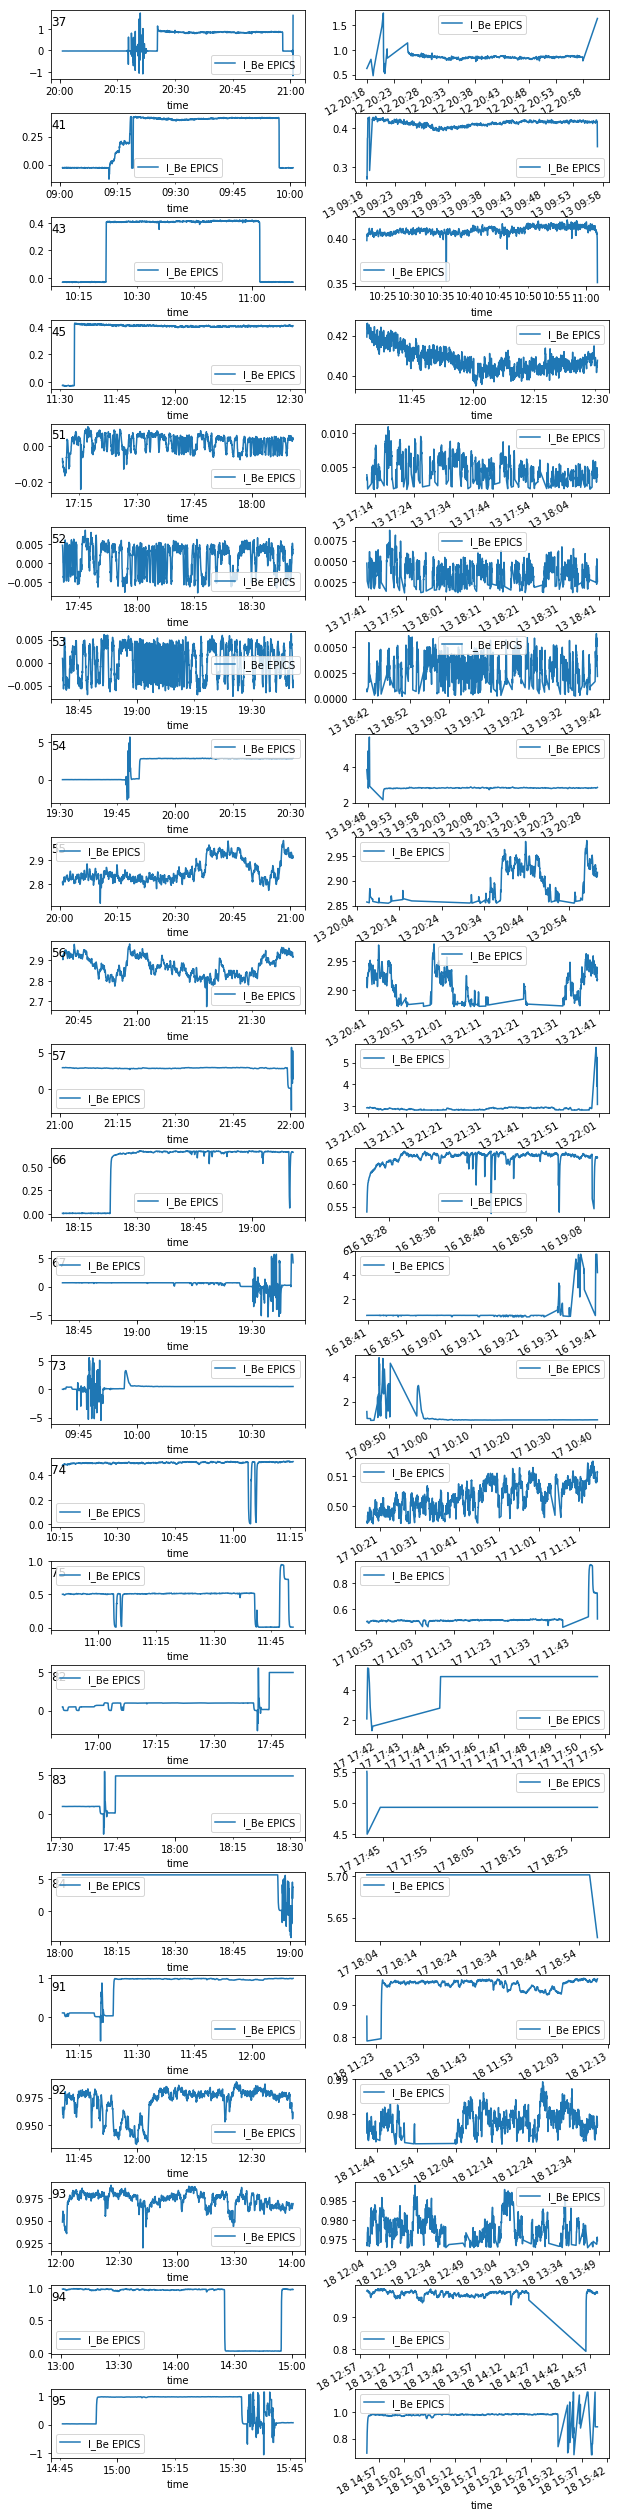

In [385]:
fig, ax = plt.subplots(df_EPICS['run_number'].nunique(),2, figsize = (10,50))

fig.subplots_adjust(hspace=.5)

for num,run in enumerate(df_EPICS['run_number'].unique()):
    
    ax1 = ax[num,0]
    ax1.set_title(str(run), loc='left', pad=-15.)
    
    ax2 = ax[num,1]
    
    df_run =  df_EPICS[(df_EPICS['run_number'] == run)]
    
    # plot regular measurement
    df_run.plot('time',
                'I_Be EPICS',
                ax = ax1
               )
    
    # mean of currents
    mean = df_run['I_Be EPICS'].mean()
    
    # df with currents only above mean
    df_filter = df_run[df_run['I_Be EPICS'] >= mean]
    
    # mean & std of new df
    mean_filter = df_filter['I_Be EPICS'].mean()
    std_filter = df_filter['I_Be EPICS'].std()
    
   
        
    df_filter.plot('time',
                   'I_Be EPICS',
                   ax = ax2
                  )
        
    



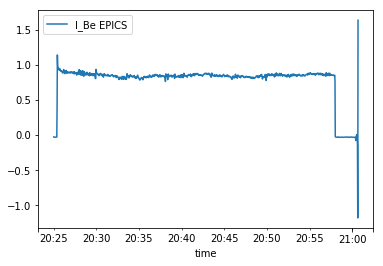

In [380]:
df_EPICS[(df_EPICS['run_number'] == 37) & (df_EPICS['sec'] >= 1523557500)].plot('time', 'I_Be EPICS')
# time doesnt match!!

In [337]:
# filter measurement time intervals
df_EPICS_filter = df_EPICS[df_EPICS['time'].apply(lambda x: x.time()).between(df_EPICS['Start'],df_EPICS['End'])]

In [338]:
df_EPICS_mean = df_EPICS_filter.groupby('run_number').agg({'I_Be EPICS':['mean','std']}).reset_index().sort_values('run_number')

# make multiindex to single level index for merging
df_EPICS_mean.columns = [' '.join(col).strip() for col in df_EPICS_mean.columns.values]

In [339]:
# compare EPICS current values to our current values
df_total[
    ['run_number',
     'particle',
     'Target',
     'energy [MeV]',
     'I_Be mean_MR',
     'I_Be std_MR',
     'I_Be mean_PZ',
     'I_Be std_PZ'
    ]
].merge(df_EPICS_mean, 
        on = 'run_number',
        how = 'inner'
       ).merge(df_sense,
              on = 'run_number',
              how = 'left')

,run_number,particle,Target,energy [MeV],I_Be mean_MR,I_Be std_MR,I_Be mean_PZ,I_Be std_PZ,I_Be EPICS mean,I_Be EPICS std,curr_sense
0,41,Proton,Be,20,0.386435,0.066667,"0,3864","0,0667",0.411122,0.007064,10.0
1,43,Proton,Be,20,0.385403,0.065672,"0,3854","0,0657",0.409595,0.004102,10.0
2,45,Proton,Be,20,0.384976,0.064492,"0,385","0,0645",0.409994,0.005910,10.0
3,51,Proton,Be,10,0.004428,0.083939,"0,0044","0,0839",0.002320,0.003918,10.0
4,52,Proton,Be,10,0.003544,0.083867,"0,0035","0,0839",0.000988,0.003609,10.0
5,53,Proton,Be,10,0.003069,0.083261,"0,0031","0,0833",0.000251,0.003509,10.0
6,54,Proton,Be,10,2.630542,0.084004,"2,6305","0,084",2.823561,0.018231,0.1
7,55,Proton,Be,10,2.673217,0.094179,"2,6732","0,0942",2.870303,0.047506,0.1
8,56,Proton,Be,10,2.662930,0.094292,"2,6629","0,0943",2.858548,0.046084,0.1
9,57,Proton,Be,10,2.688699,0.095395,"2,6887","0,0954",2.886260,0.049868,0.1


### testing

In [242]:
with open(PATH_TO_DATA + 'RawData/Gamma/' + '#34_40MeV_protonen_mit_Be.itx', newline = '') as file:
    lines = file.readlines()
    start = [num for num,s in enumerate(lines) if 'BEGIN' in s]
    end = [num for num,s in enumerate(lines) if 'END' in s]
    values = lines[start[0]+1:end[0]]
    values = [int(item.strip()) for item in values]
    
        